(Group ?)

(Benjamin Fletcher, Konrad Retzlaff, Sebastian Schmülling)

(i6308020, i6331164, i6304238)

**Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow)**: *list websites where you found code (or other info) as well as include information on how you used genAI tools*



- **For the purpose of debugging, debugging plots and annoying dataframe looping we used ChatGPT and CoPilot (GPT, Claude ect.). To get information about packagages we referenced back to the package documentation.**

- **Additionally, autocompletion was used, which may be noticeable in more generic-looking parts of the script.**

# Data Analysis, Clinic 3

By completing and delivering the clinic tasks you will know how to :

1. Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
1. Explain and tackle issues like missing values or class inbalance in your dataset
1. Judge the results of a classification model using AUROC scores
1. Select a proper algorithm that works well with your data using techniques like:
    * Cross Validation
    * Regularization
    
---
### Important Dates

- Clinic release: Tue, 18th Feb
- **Clinic due**: Fri, 28th Feb late night (wildcards possible, apply to the group)
---
##  Some rules

* For this clinic, like the previous one, we are asking you to use specific libraries that are included in the `requirements.txt`. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.

* Make sure that you include a proper amount/mix of comments, results and code. More specifically, be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice. To avoid confusion: use short comments for longer code answers.

* Back up any hypotheses and claims with data, since this is an important aspect of the course.

* Please write all your comments in English, and use meaningful variable names (as possible) in your code. 

* In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook. We will not run your notebook for you! 

- In continuation to the previous point, interactive plots, such as those generated using the ‘plotly’ package, should be strictly avoided! Make sure to print results and/or dataframes that confirm you have properly addressed the task.

* You are asked to deliver **only your executed notebook file, .ipnyb** and nothing else. If you deliver other files, we will not grade anything.

* Honor code applies to these tasks. If you are not certain about an action, consult with Jerry.

**A Note from Jerry on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating (that does not only apply to LMs). Fortunately, my job is not to police, but rather to educate you. So, please consider the following:

I assume that you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!

I don't restrict the use of LMs because I see the value of being helped when coding (esp. in the context of pandas dataframes nightmare :)). Based on what we saw last year in your notebooks, it's pretty clear when you "copy" some code and then you struggle to interpret the results. This is the essence of this course and of the skills you should try build for yourself: Many people can run fancy models these days but not many people can interpret the results correctly. Try to be the latter ones.


# Context

In this clinic, we will continue navigating the amazing world of modeling and explore classification models under extreme inbalance and missing values scenarios.

The first part of the assignment (Questions 1-9) will help you understand the impact of inbalance and missingness in the classification performance and explore different scenarios on how to improve. Most steps are laid out for you, but you are welcome to deviate.

The second part of the assignment (Question 10) is purposefully left open-ended (as in the previous clinics). In this case, you will be allowed to compare different classifiers of your choice in an effort to deal with the imbalance in the data. You can also implement some of the techniques we discussed in class about imbalances. 

## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 3
[Question 3](#q3) | 4
[Question 4](#q4) | 4
[Question 5](#q5) | 4
[Question 6](#q6) | 6
[Question 7](#q7) | 4
[Question 8](#q8) | 8
[Question 9](#q9) | 4
[Question 10](#q10)| 15 
Total | 55

This score will be scaled down to 1 and that will be your final clinic score.

In [109]:
#feel free to include additional libraries, as long as they are included in the requirements.txt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [110]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [111]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth

In [112]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


### Question 1 <a name="q1"></a>

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**Your answer goes here**

Poor Health Count:  99
Not Poor Health Count:  1452
Percentage of Poor Health:  6.382978723404255
Percentage of Not Poor Health:  93.61702127659575


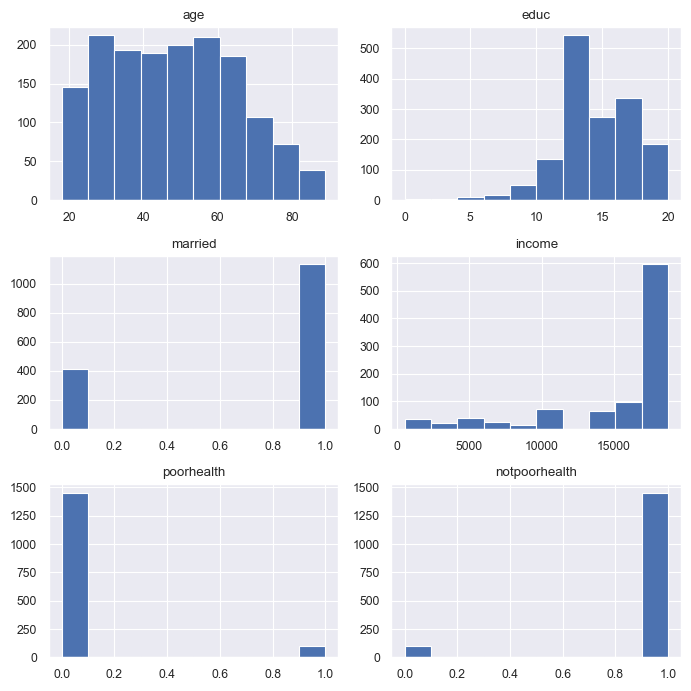

In [113]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS


poorhealth_count  = gssdata['poorhealth'].sum()
notpoorhealth_count = gssdata['notpoorhealth'].sum()
total = len(gssdata)
print("Poor Health Count: ", poorhealth_count)
print("Not Poor Health Count: ", notpoorhealth_count)
percentage_poorhealth = (poorhealth_count/total)*100
percentage_notpoorhealth = (notpoorhealth_count/total)*100
print("Percentage of Poor Health: ", percentage_poorhealth)
print("Percentage of Not Poor Health: ", percentage_notpoorhealth)

#b)
# From the above output, we can see that the percentage of poor health is 6.4% and the percentage of not poor health is 94%. This shows that the data is imbalanced.
# In this case the minority class is poor health and the majority class is not poor health.

#c)
# The accuracy of a classifier that predicts everybody NOT being in poor health would be 93.617%.


#d)
# Well as discussed in class in the case of imbalanced data, accuracy is not a good metric to evaluate the model. This is because the model can predict the majority class with high accuracy but it will fail to predict the minority class.
# In this case, the model will predict the majority class with 93.617% accuracy but it will fail to predict the minority class.
# If we want to classfiy the minority class we would have a low accuracy (6.4%) while still predicting all correctly. 
# This is why accuracy is not a good metric to evaluate the model in the case of imbalanced data.

gssdata.hist(figsize=(7,7))
plt.tight_layout()

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (`ValueError: Input contains NaN, infinity or a value too large for dtype('float64')`.) So you can also consider not using that variable in the model

In [114]:
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,notpoorhealth
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,1
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,0


In [115]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [116]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,False,False,True,False,False,False,True,False,False,True
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,False,False,True,False,False,True,False,False,False,True
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,False,False,True,False,False,True,False,False,False,True


In [117]:
gssdata.columns

gssdata.dtypes

health                               object
age                                   int64
sex                                  object
educ                                  int64
sexornt                              object
partyid                              object
race                                 object
married                               int64
income                              float64
poorhealth                            int64
notpoorhealth                         int64
female                                int64
sexornt_bisexual                       bool
sexornt_dont know                      bool
sexornt_heterosexual or straight       bool
sexornt_homosexual or gay              bool
partyid_dem                            bool
partyid_other                          bool
partyid_rep                            bool
race_black                             bool
race_other                             bool
race_white                             bool
dtype: object

### Question 2 <a name="q2"></a>

In the code below try to fit your logistic regression model and provide some short comments on the performance of the model. You don't need to be detailed (yet), but make sure to make 1-2 observations at least.

In [118]:
######HERE YOUR CODE TO FIT THE MODEL
######
######
######Look up LogisticRegression() from scikitlearn
from sklearn.model_selection import train_test_split


# drop the columns with categorical data
X = gssdata.drop(['poorhealth', 'notpoorhealth', 'health','sex', 'sexornt', 'partyid', 'race', 'income'], axis=1)
#print(X.head())

y = gssdata['poorhealth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)

Model accuracy: 0.9196141479099679


/opt/anaconda3/envs/data_analysis_cours/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Your answer goes here**

---

**Observations**:

- Model seems to have a good accuracy for predicting poor health.

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

### Question 3 <a name="q3"></a>

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this.

Number of rows before droping NaN rows:  1551
Number of rows after droping NaN rows:  963
Total rows dropped:  588
Poor Health Count before droping NaN rows:  99
Poor Health Count after droping NaN rows:  16


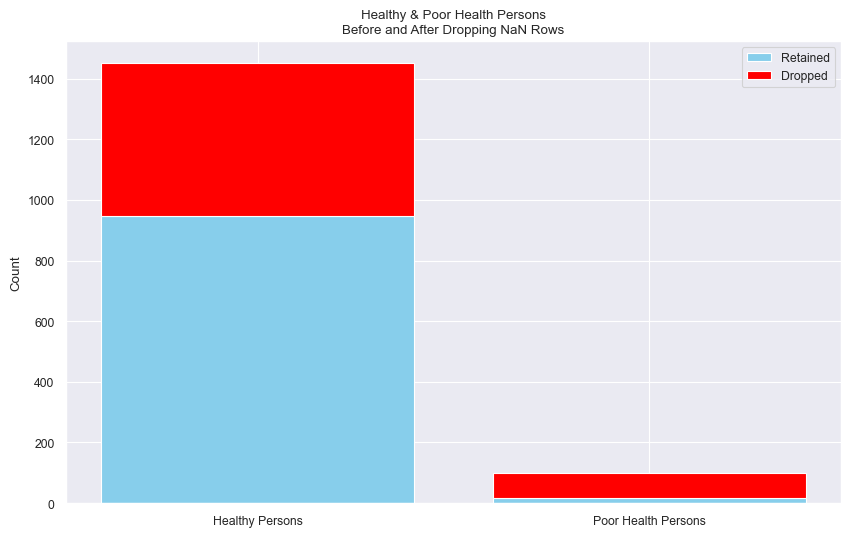

,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
5,excellent,30,female,15,heterosexual or straight,other,other,1,18750.0,0,...,False,False,True,False,False,True,False,False,True,False
9,excellent,30,female,14,heterosexual or straight,other,black,1,16250.0,0,...,False,False,True,False,False,True,False,True,False,False
12,good,38,female,15,heterosexual or straight,dem,white,0,18750.0,0,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,good,62,male,12,heterosexual or straight,rep,white,1,18750.0,0,...,False,False,True,False,False,False,True,False,False,True
1547,good,56,male,12,heterosexual or straight,other,white,1,18750.0,0,...,False,False,True,False,False,True,False,False,False,True
1548,excellent,24,male,14,heterosexual or straight,dem,white,0,11250.0,0,...,False,False,True,False,True,False,False,False,False,True
1549,fair,27,male,13,heterosexual or straight,dem,white,0,18750.0,0,...,False,False,True,False,True,False,False,False,False,True


In [119]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.


gssdata_full = gssdata.dropna()

print("Number of rows before droping NaN rows: ", len(gssdata))
print("Number of rows after droping NaN rows: ", len(gssdata_full))
print("Total rows dropped: ", len(gssdata) - len(gssdata_full))


poorhealth_count_full  = gssdata_full['poorhealth'].sum()
poorhealth_count = gssdata['poorhealth'].sum()
print("Poor Health Count before droping NaN rows: ", poorhealth_count)
print("Poor Health Count after droping NaN rows: ", poorhealth_count_full)
#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)


#We will do a barplot

healthy_count = len(gssdata) - poorhealth_count
healthy_count_full = len(gssdata_full) - poorhealth_count_full

dropped_healthy = healthy_count - healthy_count_full
dropped_poorhealth = poorhealth_count - poorhealth_count_full

plt.figure(figsize=(10,6))
plt.bar("Healthy Persons", healthy_count_full, color="skyblue", label="Retained")
plt.bar("Healthy Persons", dropped_healthy, bottom=healthy_count_full, color="red", label="Dropped")
plt.bar("Poor Health Persons", poorhealth_count_full, color="skyblue")
plt.bar("Poor Health Persons", dropped_poorhealth, bottom=poorhealth_count_full, color="red")
plt.ylabel("Count")
plt.title("Healthy & Poor Health Persons\nBefore and After Dropping NaN Rows")
plt.legend()
plt.show()

gssdata_full #<---this should be your final data frame.

In [120]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split

#added seed for reproducibility
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25, random_state=42)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

**Your answer goes here**

In total we dropped 588 rows from the original dataset. The total number of poor health persons dropped was 99 and 16 after dropping all NaN rows.
The amount of dropped rows is compareable higher for healthy persons. However, given the already imbalanced dataset, where the majority of persons are healthy, the amount of dropped healthy persons is still much higher than the amount of dropped poor health persons.
This can can be nicely seen in the barplot above.

### Question 4 <a name="q4"></a>

Fit a logistic regression mode with `C=1000000` (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [121]:
from sklearn.metrics import accuracy_score

#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit1 = LogisticRegression(C=1000000, solver='liblinear')
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

#logit1
logit = logit1
#<-- this should be the name of your model so as to work below with the confusion matrix 
      #(or if you have a different name, then change it there as well)

Accuracy on test set: 0.975103734439834


**Your answer goes here**

We observe a very high accuracy, but this does not necessarily indicate good model performance. Since we are predicting for poor health (the minority class), the high accuracy may be misleading. Given the low total number of poor health instances, the model might be predicting only a few of them correctly while still achieving a high accuracy due to the majority class (healthy individuals) It could basically "cheat" by always predicting the majority class and still achieve high accuracy.

- **Note**: This assumption gets validated further down by the confusion matrix. The model just predicts the majority class for all instances in the test set. This can be seen because there are only TN and (in this run) 4 FN. So the only 4 postive instances of the test set are getting predicted wrong. 

In [122]:
print("Number of true poor health instances in the test set:",y_test.sum())

Number of true poor health instances in the test set: 6


## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [123]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))

[[235   0]
 [  6   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [124]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [125]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit1, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[223  12]
 [  5   1]]
[[678  34]
 [  8   2]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [126]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

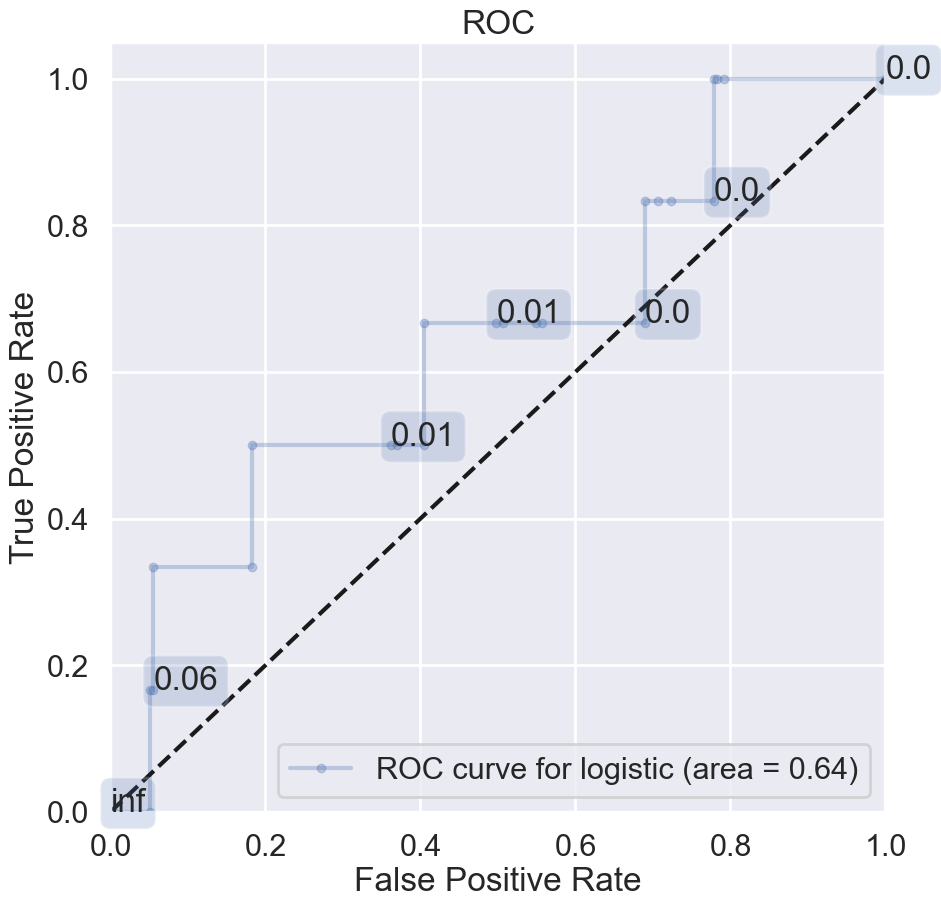

In [127]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit1, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 5 <a name="q5"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**Your answer goes here**

The ROC curve gives us an AUC value of 0.64. This is a fairly poor performance given that a predictor that predicts at random has an AUC value of 0.5. One can also see that the ROC curve follows a same trajectory as the dotted line (which is prediction at random).

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

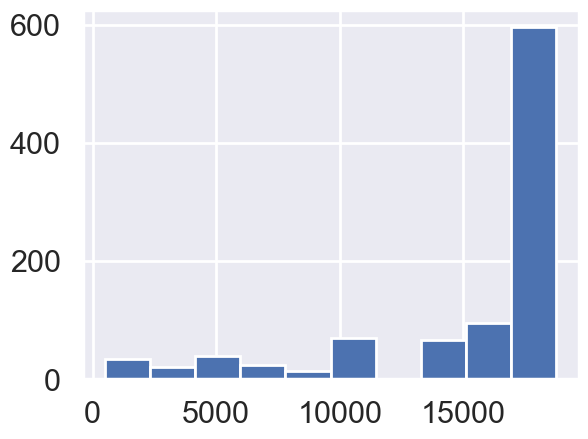

In [128]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

### Question 6 <a name="q6"></a>

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

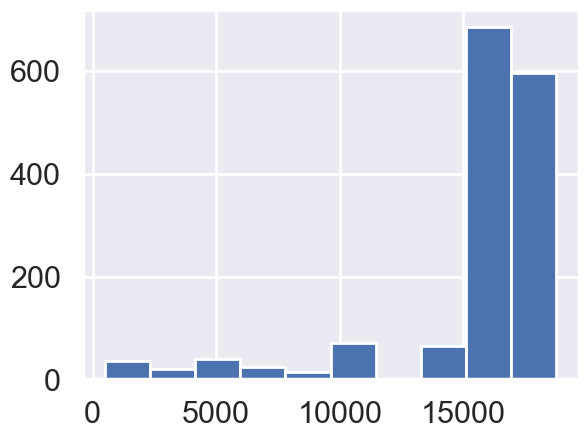

In [129]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!

gssdata_imputed = gssdata.copy()
gssdata_imputed['income'] = gssdata_imputed['income'].fillna(gssdata_imputed['income'].mean())
hist = plt.hist(gssdata_imputed['income'])


In [130]:
###here, do a proper train/test split and a model training

itrain, itest = train_test_split(range(gssdata_imputed.shape[0]), test_size=0.25, random_state=42, stratify=gssdata_imputed['poorhealth'])


#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_imputed[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_imputed['poorhealth'].iloc[itrain]
y_test = gssdata_imputed['poorhealth'].iloc[itest]


logit2 = LogisticRegression(C=1000000, solver='liblinear')
logit2.fit(X_train, y_train)
y_pred = logit1.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

# TODO Should we do stratification here already?, Should swe still use C=1000000?

Accuracy on test set: 0.9355670103092784


In [131]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################


print(confusion_matrix(y_test,t_repredict(logit2, 0.06, X_test)))
print(confusion_matrix(y_test,t_repredict(logit2, 0.1, X_test)))
print(confusion_matrix(y_test,t_repredict(logit2, 0.15, X_test)))
print(confusion_matrix(y_test,t_repredict(logit2, 0.2, X_test)))
#print(confusion_matrix(y_train,t_repredict(logit1, 0.06, X_train)))

[[213 150]
 [  7  18]]
[[299  64]
 [ 13  12]]
[[336  27]
 [ 18   7]]
[[352  11]
 [ 21   4]]


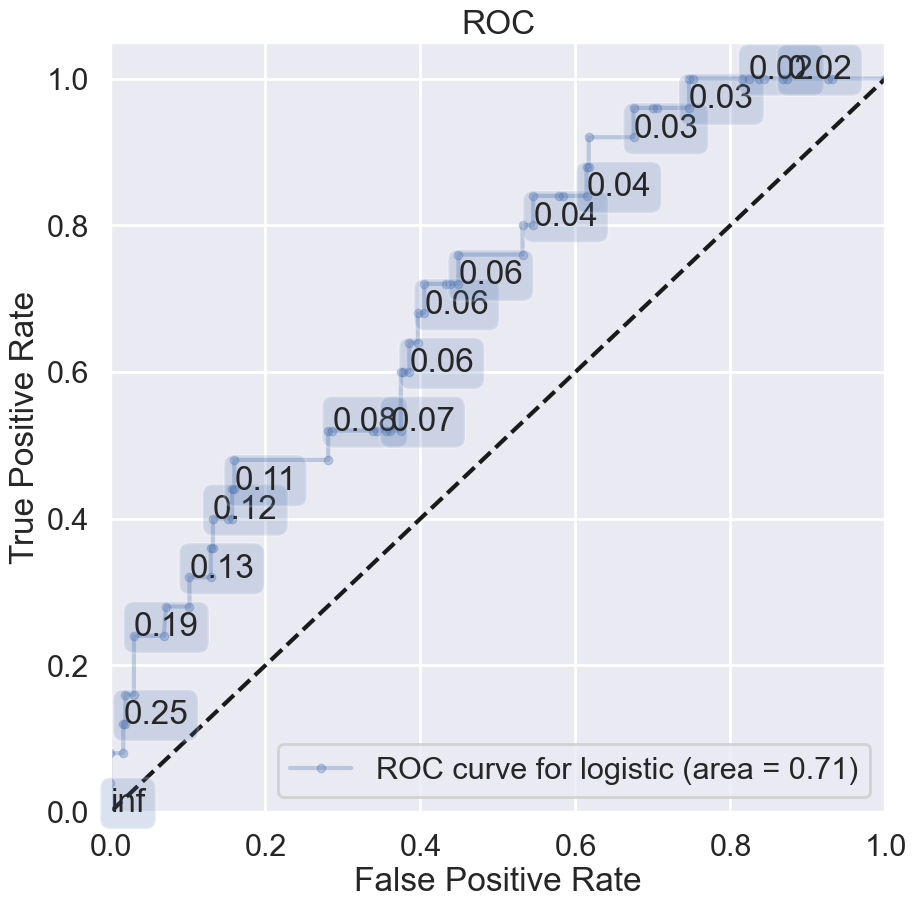

In [132]:
#####################
# your code here: create an ROC curve
#####################


sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit2, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 7 <a name="q7"></a>


What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

We can see a much better fit on the data in comparison to our old model. The AUC value is 0.71 which tells us that we got 0.8 higher AUC value than before. However there is room of improvement since the ROC curve still follows the line of the random guess ROC line somewhat parallel. 



---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

### Question 8 <a name="q8"></a>

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [133]:
#use the dataset without NAs here
#train a model

#####################
# your code here: 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


#create df with selected columns to build the model
df_gssdata_selected = gssdata[['age', 'educ','income']].copy()
dummy_vars = pd.get_dummies(gssdata[['sex', 'partyid']], drop_first=True)
df_gssdata_selected = df_gssdata_selected.join(dummy_vars)


#create dataframe with missing values for income to later predict them
missing_mask = df_gssdata_selected['income'].isnull()
missing_indices = df_gssdata_selected[missing_mask].index
df_gssdata_missing = df_gssdata_selected[missing_mask].copy()

#now we drop the rows with missing values
df_gssdata_train = df_gssdata_selected.dropna(subset=['income']).copy()


X_features = ['age', 'educ'] + list(dummy_vars.columns)
X = df_gssdata_train[X_features]
y = df_gssdata_train['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

# Train model
lin_model_income = LinearRegression()
lin_model_income.fit(X_train, y_train)
y_pred = lin_model_income.predict(X_test)

print("\nModel Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))


X_missing = df_gssdata_missing[X_features]
predicted_income = lin_model_income.predict(X_missing)

#####################


Model Performance:
R² Score: 0.1408038980221309
Mean Absolute Error (MAE): 3358.662898421874
Mean Squared Error (MSE): 21255151.48838804
Root Mean Squared Error (RMSE): 4610.330952153873


Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [134]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = predicted_income, index = missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

count     1551.000000
mean     15757.720146
std       4231.971841
min        500.000000
25%      13888.230747
50%      17185.043511
75%      18750.000000
max      21777.827999
Name: income, dtype: float64

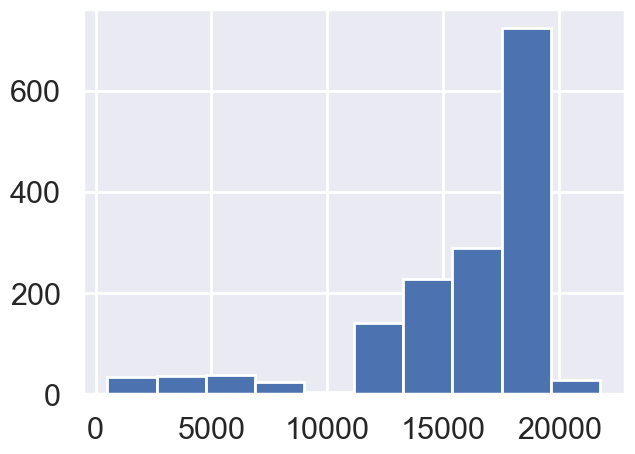

In [135]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [136]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)

itrain, itest = train_test_split(range(gssdata_imp.shape[0]), test_size=0.25, random_state=42, stratify=gssdata_imp['poorhealth'])


#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_imp[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_imputed['poorhealth'].iloc[itrain]
y_test = gssdata_imputed['poorhealth'].iloc[itest]

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

In [137]:
#here you fit a model
#should be called logit3

logit3 = LogisticRegression(C=1000000, solver='liblinear')
logit3.fit(X_train, y_train)
y_pred = logit1.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

# TODO Should we do stratification here already?, Should swe still use C=1000000?

Accuracy on test set: 0.9355670103092784


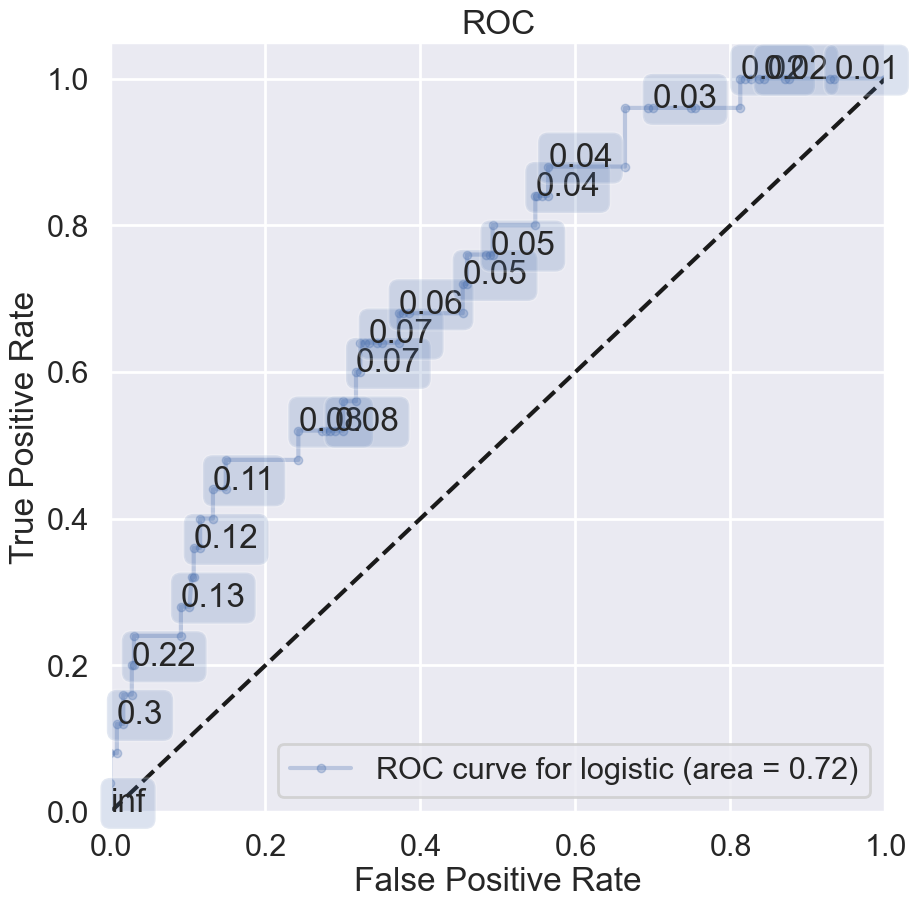

In [139]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE
#####################
# your code here: create an ROC curve
#####################
sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit2, y_test, X_test, labe=4, skip=0)
plt.show()

### Question 9 <a name="q9"></a>


Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**

## Part 3: Improving the model.

### Question 10 <a name="q10"></a>


Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

For this question, you are also free (but not onbliged) to use techniques to address class imbalances (as we discussed in class) both on the data or model level. Recall that each method has advantages and disadvantages, so you will need to correctly interpret the results and assess the performance of any method you choose on the problem we explore here. Some examples can be found [here](https://imbalanced-learn.org/stable/index.html). 

In [ ]:
## your code goes here